# Laboratory 3
(Lumalang, Carl John D.,
Morales, Johann Daniel P.,
Morillo, Jerime B.)

# 1. Initialize Spark Session

In [1]:
!pip install -q findspark
!pip install pyspark==3.5.0 # Install the corresponding PySpark version
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Lumalang, Morales, Morillo") \
       .getOrCreate()
spark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=220065ffd2cad2593bdf51f5d261313eb78f189d5886cb183ae0b1b96e5e21ce
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1


In [2]:
import warnings

from pyspark.sql.types import NumericType
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import combinations
from wordcloud import WordCloud
import re

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import when, col, round

# 2. Load Your Own Dataset

In [10]:
df = spark.read.csv('credit_score_train.csv',inferSchema=True, header=True)
df.filter(df['credit_score'] == 1).show()

+------+-----------+--------+---------------+---+-----------+------------+-------------+---------------------+------------------+-------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+---------------------+-----------------------+--------------------+---------------+------------+
|    id|customer_id|   month|           name|age|        ssn|  occupation|annual_income|monthly_inhand_salary|credit_history_age|total_emi_per_month|num_bank_accounts|num_credit_card|interest_rate|num_of_loan|        type_of_loan|delay_from_due_date|num_of_delayed_payment|changed_credit_limit|num_credit_inquiries|credit_mix|outstanding_debt|credit_utilization_ratio|payment_of_min_amount|amount_invested_monthly|   payment_behaviour|monthly_balance|credit_score|
+------+-----------+--------+---------------+---+-----------+---------

# 3. ETL: Data Cleaning & Feature Engineering

In [4]:
df.describe().show()

+-------+-------+-----------+-----+------+------------------+-----------+----------+------------------+---------------------+------------------+-------------------+-----------------+-----------------+------------------+------------------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+------------------+------------------------+---------------------+-----------------------+--------------------+------------------+------------------+
|summary|     id|customer_id|month|  name|               age|        ssn|occupation|     annual_income|monthly_inhand_salary|credit_history_age|total_emi_per_month|num_bank_accounts|  num_credit_card|     interest_rate|       num_of_loan|        type_of_loan|delay_from_due_date|num_of_delayed_payment|changed_credit_limit|num_credit_inquiries|credit_mix|  outstanding_debt|credit_utilization_ratio|payment_of_min_amount|amount_invested_monthly|   payment_behaviour|   monthly_balance|      cred

Pandas Dataframe for Visualization of Correlation Heatmaps and Easier Feature Engineering

In [5]:
pdf = pd.read_csv('credit_score_train.csv')
pdf.head()

,id,customer_id,month,name,age,ssn,occupation,annual_income,monthly_inhand_salary,credit_history_age,...,changed_credit_limit,num_credit_inquiries,credit_mix,outstanding_debt,credit_utilization_ratio,payment_of_min_amount,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8434,89,...,11.27,4,Good,809.98,26.822620,No,80.415300,High_spent_Small_value_payments,312.49408,2
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8434,93,...,11.27,4,Good,809.98,31.944960,No,118.280220,Low_spent_Large_value_payments,284.62915,2
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8434,91,...,11.27,4,Good,809.98,28.609352,No,81.699524,Low_spent_Medium_value_payments,331.20987,2
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8434,92,...,6.27,4,Good,809.98,31.377861,No,199.458070,Low_spent_Small_value_payments,223.45131,2
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8434,93,...,11.27,4,Good,809.98,24.797346,No,41.420155,High_spent_Medium_value_payments,341.48923,2


In [6]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96696 entries, 0 to 96695
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        96696 non-null  object 
 1   customer_id               96696 non-null  object 
 2   month                     96696 non-null  object 
 3   name                      96696 non-null  object 
 4   age                       96696 non-null  int64  
 5   ssn                       96696 non-null  object 
 6   occupation                96696 non-null  object 
 7   annual_income             96696 non-null  float64
 8   monthly_inhand_salary     96696 non-null  float64
 9   credit_history_age        96696 non-null  int64  
 10  total_emi_per_month       96696 non-null  float64
 11  num_bank_accounts         96696 non-null  int64  
 12  num_credit_card           96696 non-null  int64  
 13  interest_rate             96696 non-null  int64  
 14  num_of

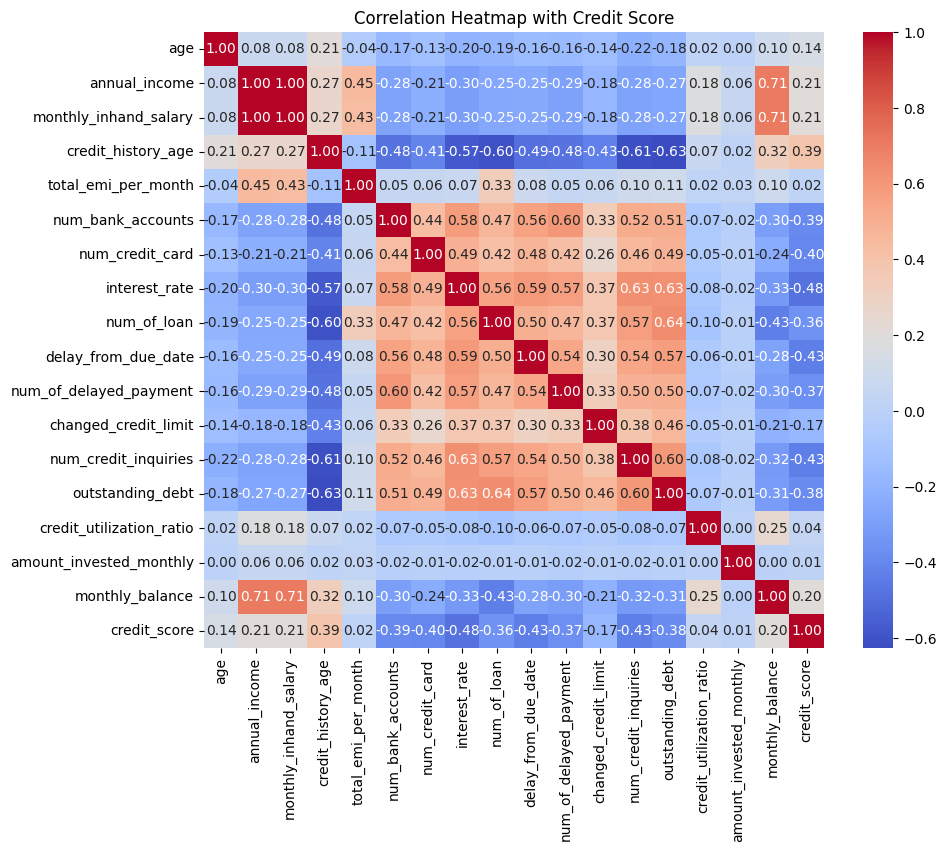

In [7]:
numeric_df = pdf.select_dtypes(include="number")

plt.figure(figsize=(10, 8))

correlation_matrix = numeric_df.corr()

#Plotting
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title("Correlation Heatmap with Credit Score")
plt.show()

# 4. Machine Learning Model: Logistic Regression

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib

# 1. Feature Selection
features = [
    'credit_history_age', 'monthly_balance', 'monthly_inhand_salary', 'annual_income',
    'interest_rate', 'outstanding_debt', 'num_of_loan', 'delay_from_due_date',
    'num_of_delayed_payment', 'total_emi_per_month', 'num_credit_inquiries'
]
X = pdf[features]
y = pdf['credit_score']  # Multiclass target: 0, 1, 2

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Pipeline with PolynomialFeatures + LogisticRegression (for interaction terms)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("logreg", LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        C=0.5,              # L2 Regularization strength (you can tune this)
        random_state=42
    ))
])

# 4. Train model
pipeline.fit(X_train, y_train)

# 5. Predict
y_pred = pipeline.predict(X_test)

# 6. Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

joblib.dump(pipeline, 'logistic_regression_model.pkl')
print("Model saved successfully!")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.6320
Confusion Matrix:
 [[3130 2133  234]
 [1622 7789  890]
 [  60 2179 1303]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.57      0.61      5497
           1       0.64      0.76      0.70     10301
           2       0.54      0.37      0.44      3542

    accuracy                           0.63     19340
   macro avg       0.61      0.56      0.58     19340
weighted avg       0.63      0.63      0.62     19340

Model saved successfully!


# 5. Visualizations for Dashboard Insights

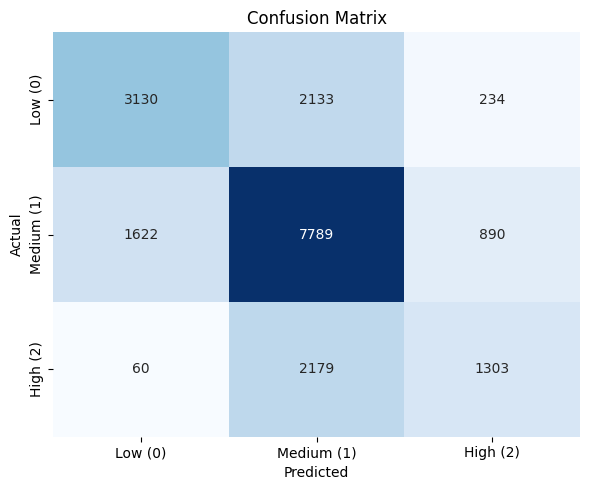

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low (0)', 'Medium (1)', 'High (2)'],
            yticklabels=['Low (0)', 'Medium (1)', 'High (2)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
unique_preds = np.unique(y_pred, return_counts=True)
print("Unique predicted classes and their counts:", dict(zip(*unique_preds)))

Unique predicted classes and their counts: {np.int64(0): np.int64(4812), np.int64(1): np.int64(12101), np.int64(2): np.int64(2427)}


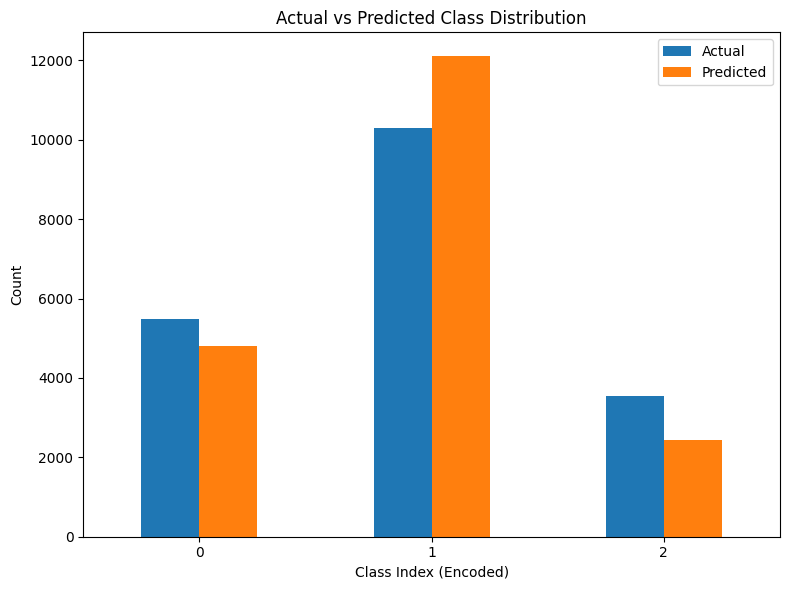

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for actual and predicted class counts
counts = pd.DataFrame({
    'Actual': y_test.value_counts().sort_index(),
    'Predicted': pd.Series(y_pred).value_counts().sort_index()
})

# Plotting
counts.plot(kind='bar', figsize=(8, 6))
plt.title("Actual vs Predicted Class Distribution")
plt.xlabel("Class Index (Encoded)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

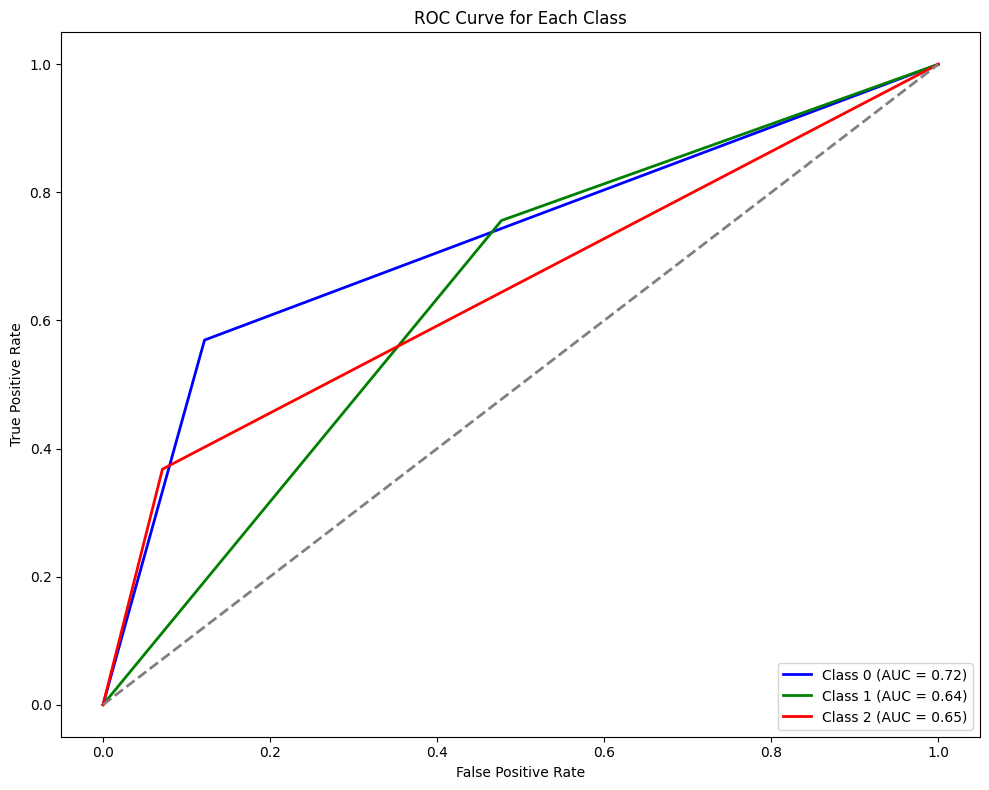

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Binarize the target labels for multiclass classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])

# Initialize a plot for the ROC curve
plt.figure(figsize=(10, 8))

# Loop through each class (0, 1, 2) and plot its ROC curve
colors = ['blue', 'green', 'red']  # Color for each class curve
for i in range(3):
    # Calculate the ROC curve for class i
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)  # Compute the area under the curve (AUC)

    # Plot the ROC curve for class i
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal (random classifier) for reference
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Add title and labels
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()

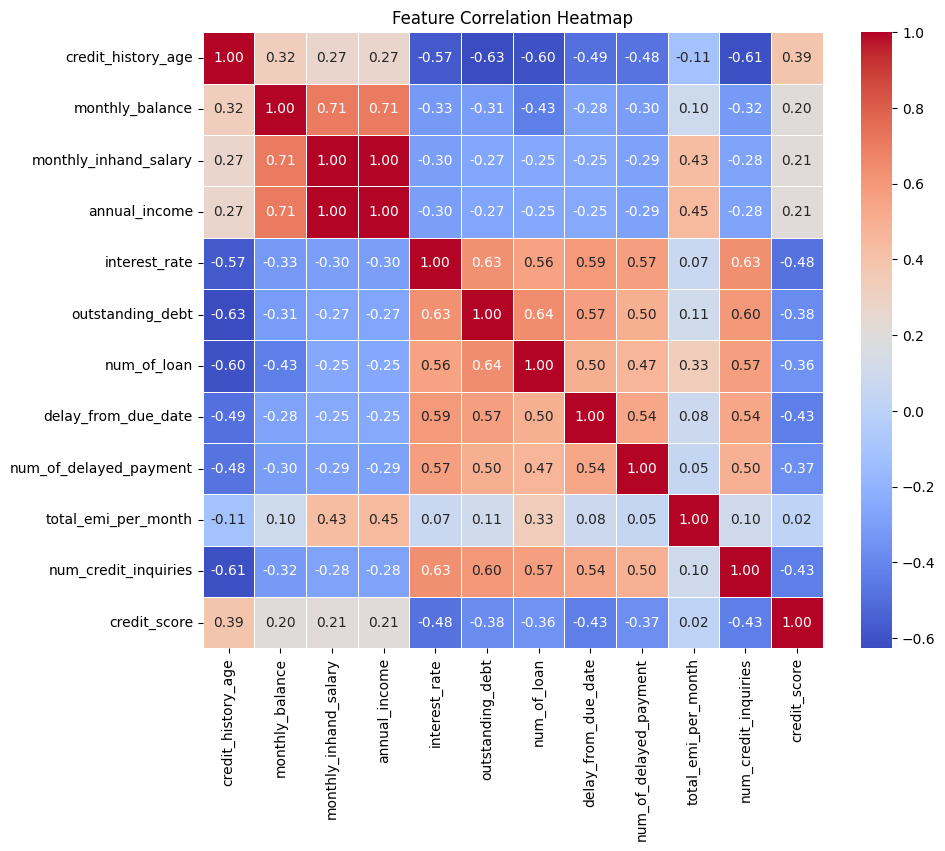

In [ ]:
correlation_matrix = pdf[features + ['credit_score']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()